In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [2]:
# To supress the scientific notation for easier reading.
np.set_printoptions(suppress=True)

# Test Development

In developing the code, three main tests have been completed within one region: Amhara. The first at a very micro level with a custom dummy dataset with only two primary schools and 2 proposed secondary schools. The second is for one woreda/district with 21 primary schools and two secondary schools, whereby 5 secondary schools are proposed. The final test was a region wide test with 1765 primary schools and 1658 secondary schools, with 5 new secondary schools proposed.

In [3]:
# Specify which test to perform
declare_test = 2 # micro test

In [4]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2:
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else:
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

## Data Preparation

In [6]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

<ipython-input-6-16a4cd06d1a3>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [6]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

## Key functions

In [7]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [8]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    answer = np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0.1, # 0.1 or not?
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))
    return answer

In [16]:
def expected_enroll(prim_loc, x, prim_enroll, sec_loc):
    x = np.append(sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    return np.sum(min_d*prim_enroll)

In [62]:
np.sum(df_sec_enroll)/ np.sum(df_prim_enroll)

0.08185178665727864

3255.0

In [10]:
def expected_enroll2(prim_loc, x, prim_enroll, sec_loc):
    x = np.append(sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    shaped_enroll = shape(min_d, prim_enroll)
    return np.sum(shaped_enroll)

In [11]:
# The Objective Function
def f(x):
    test_case = expected_enroll(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return np.round(test_case,3)

In [12]:
# The Objective Function with the shape function included.
def f2(x):
    test_case = expected_enroll2(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return np.round(test_case,3)*-1

In [13]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if declare_test == 3:
            if check_region(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()
        else:
            if check_woreda(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()

## Random Search

In [14]:
def random_search(f, n):
    x = [get_random_sp() for _ in range(n)] 
    fx = [(f(xi), xi) for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [17]:
fx = [random_search(f, 10000) for _ in range(4)]

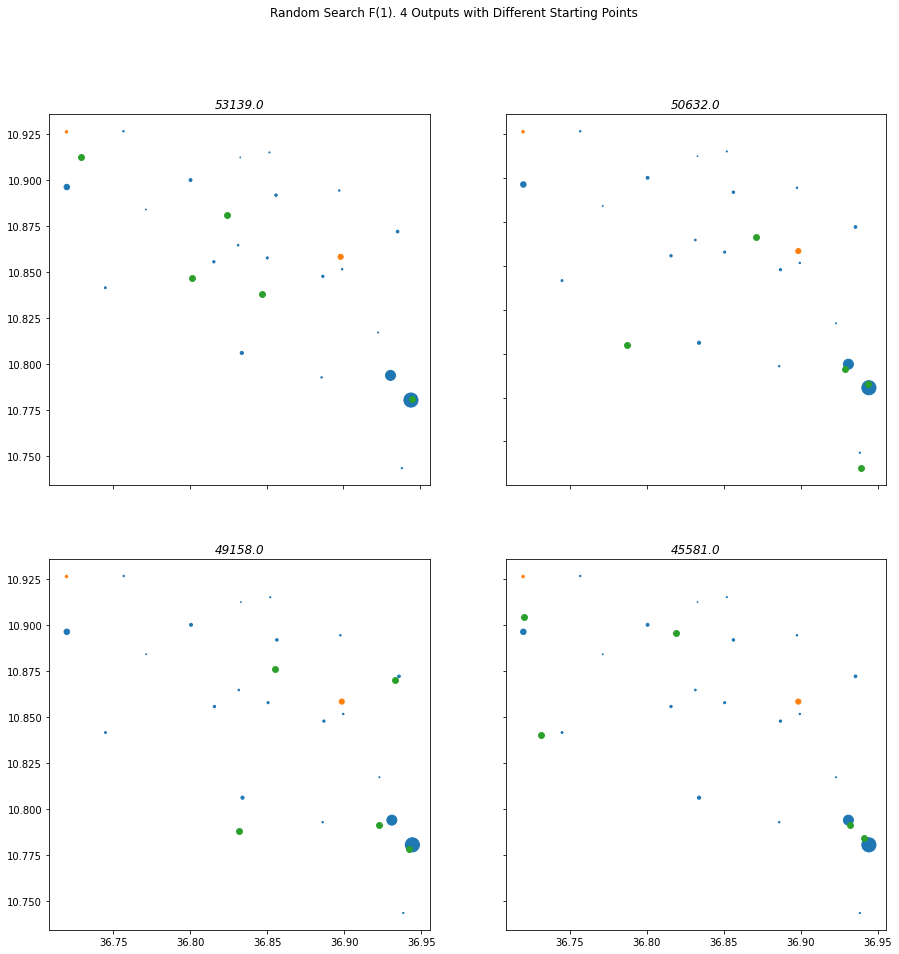

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx[i][1][1::2], fx[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [19]:
fx2 = [random_search(f2, 10000) for _ in range(4)]

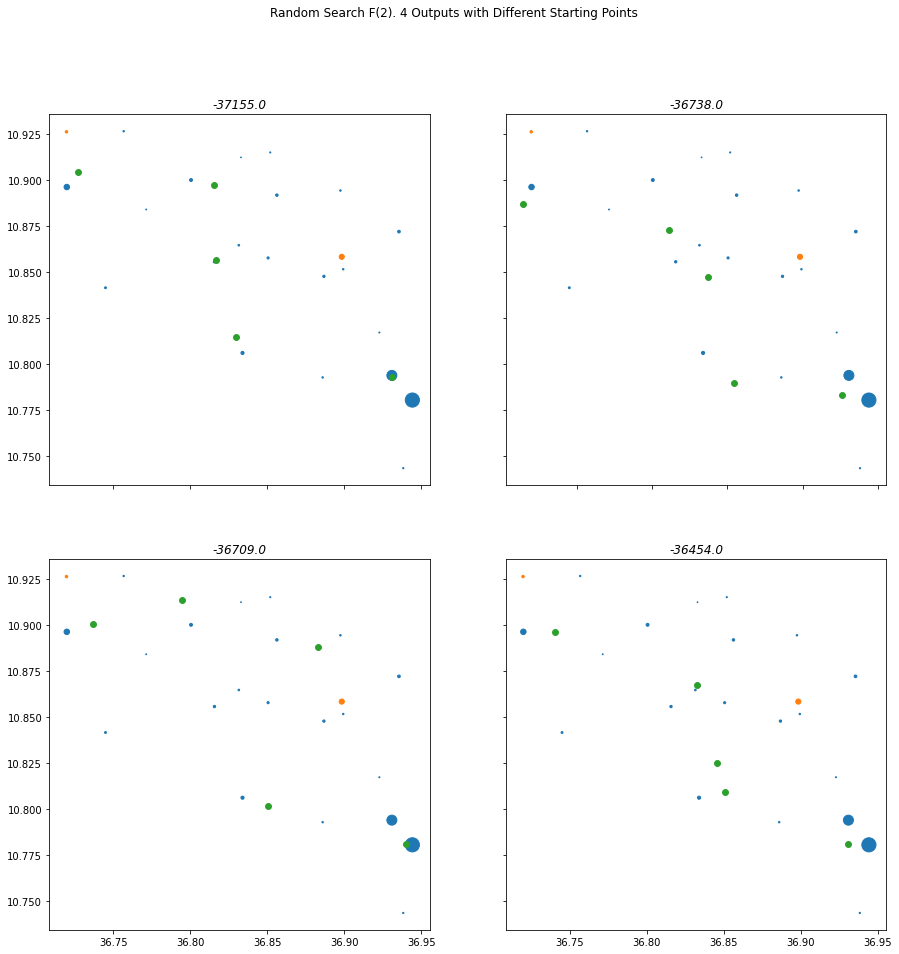

In [20]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx2[i][1][1::2], fx2[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx2[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

## CMA

In [21]:
sigmas = (0.01, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24)
maxits = 10000

In [22]:
fcma = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f, iterations=maxits / es.popsize)
        fcma.append((es.result[1], es.result[0], j))
        
fcma_s = sorted(fcma, key=lambda t: t[0])[:4]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 09:58:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.629479940000000e+05 1.0e+00 9.71e-03  9e-03  1e-02 0:00.0
    2     20 1.202521180000000e+05 1.2e+00 1.01e-02  1e-02  1e-02 0:00.0
    3     30 1.222072830000000e+05 1.3e+00 1.07e-02  1e-02  1e-02 0:00.0
  100   1000 4.015792600000000e+04 1.5e+01 1.01e-03  1e-04  1e-03 0:00.4
  200   2000 3.939868000000000e+04 5.6e+01 4.89e-05  1e-06  6e-05 0:00.7
  300   3000 3.938951500000000e+04 2.1e+02 3.52e-07  3e-09  5e-07 0:01.0
  400   4000 3.938944200000000e+04 1.6e+03 7.12e-07  3e-09  4e-06 0:01.4
  500   5000 3.938876400000000e+04 3.9e+03 2.16e-07  3e-10  1e-06 0:01.8
  526   5260 3.938876300000000e+04 5.6e+03 1.78e-07  2e-10  9e-07 0:01.9
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 09:58:57 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 9.6129

    2     20 8.020638499999999e+04 1.2e+00 1.05e-02  1e-02  1e-02 0:00.0
    3     30 6.678761700000000e+04 1.3e+00 1.04e-02  1e-02  1e-02 0:00.0
  100   1000 4.755564100000000e+04 1.8e+01 7.18e-04  6e-05  1e-03 0:00.4
  200   2000 4.702916200000000e+04 5.9e+01 2.41e-05  5e-07  3e-05 0:00.7
  300   3000 4.702617200000000e+04 7.3e+02 3.99e-06  2e-08  1e-05 0:01.0
  400   4000 4.702114300000000e+04 2.6e+03 9.14e-07  2e-09  4e-06 0:01.4
  500   5000 4.702107700000000e+04 1.4e+04 1.33e-06  1e-09  1e-05 0:02.0
NOTE (module=cma, iteration=503):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.0e+08 to 1.3e+01
  553   5530 4.702105300000000e+04 3.0e+00 3.09e-07  2e-10  3e-06 0:02.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 09:59:26 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.677663120000000e+05 1.0e+00 4.65e-02  4e-02  5e-02 0:00.0
    2     20 1.939742430000000e+

    1     10 1.404681850000000e+05 1.0e+00 9.57e-03  9e-03  1e-02 0:00.0
    2     20 1.212758330000000e+05 1.2e+00 1.00e-02  1e-02  1e-02 0:00.0
    3     30 1.033233260000000e+05 1.3e+00 1.09e-02  1e-02  1e-02 0:00.0
  100   1000 2.304598500000000e+04 1.4e+01 2.60e-03  4e-04  4e-03 0:00.4
  200   2000 2.077580100000000e+04 4.7e+01 3.86e-04  2e-05  8e-04 0:00.7
  300   3000 2.059919100000000e+04 2.6e+02 6.60e-06  1e-07  3e-05 0:01.1
  400   4000 2.058999000000000e+04 1.6e+03 1.90e-05  1e-07  2e-04 0:01.5
  500   5000 2.058709900000000e+04 3.6e+03 3.55e-07  8e-10  3e-06 0:01.9
  542   5420 2.058709200000000e+04 8.3e+03 3.62e-08  5e-11  3e-07 0:02.1
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:00:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.646322230000000e+05 1.0e+00 4.80e-02  5e-02  5e-02 0:00.0
    2     20 8.782949200000000e+04 1.2e+00 5.27e-02  5e-02  6e-02 0:00.0
    3     30 9.231749000000001e+04 

  100   1000 4.467681000000000e+04 1.6e+01 3.46e-03  4e-04  5e-03 0:00.4
  200   2000 3.748956100000000e+04 2.6e+01 6.43e-05  2e-06  4e-05 0:00.8
  300   3000 3.743663400000000e+04 3.8e+02 1.14e-05  1e-07  4e-05 0:01.2
  400   4000 3.743577300000000e+04 1.2e+03 4.62e-07  2e-09  2e-06 0:01.6
  500   5000 3.743291300000000e+04 3.3e+03 1.55e-06  2e-09  6e-06 0:02.0
  549   5490 3.743290100000000e+04 6.1e+03 1.45e-07  1e-10  7e-07 0:02.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:00:36 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 8.368572300000000e+04 1.0e+00 4.89e-02  5e-02  5e-02 0:00.0
    2     20 4.740245500000000e+04 1.2e+00 4.48e-02  4e-02  5e-02 0:00.0
    3     30 8.725526700000001e+04 1.2e+00 4.30e-02  4e-02  4e-02 0:00.0
  100   1000 5.887899200000000e+04 1.8e+01 2.48e-03  2e-04  3e-03 0:00.4
  200   2000 3.416744900000000e+04 1.7e+02 4.69e-03  9e-05  1e-02 0:00.7
  300   3000 3.050232000000000e+04 

In [23]:
fcma_s

[(20587.092,
  array([10.794     , 36.9308    , 10.87599122, 36.83000039, 10.7806    ,
         36.9441    , 10.8062    , 36.8339    , 10.8963    , 36.7199    ]),
  0.01),
 (25017.83,
  array([10.8416    , 36.74500001, 10.794     , 36.9308    , 10.7806    ,
         36.9441    , 10.86469999, 36.83149999, 10.8963    , 36.7199    ]),
  0.12),
 (25017.83,
  array([10.7806    , 36.9441    , 10.794     , 36.9308    , 10.8963    ,
         36.7199    , 10.8416    , 36.745     , 10.86469998, 36.83149999]),
  0.2),
 (26788.906,
  array([10.74359999, 36.93819999, 10.794     , 36.9308    , 10.7806    ,
         36.9441    , 10.8963    , 36.7199    , 10.86469994, 36.83149997]),
  0.1)]

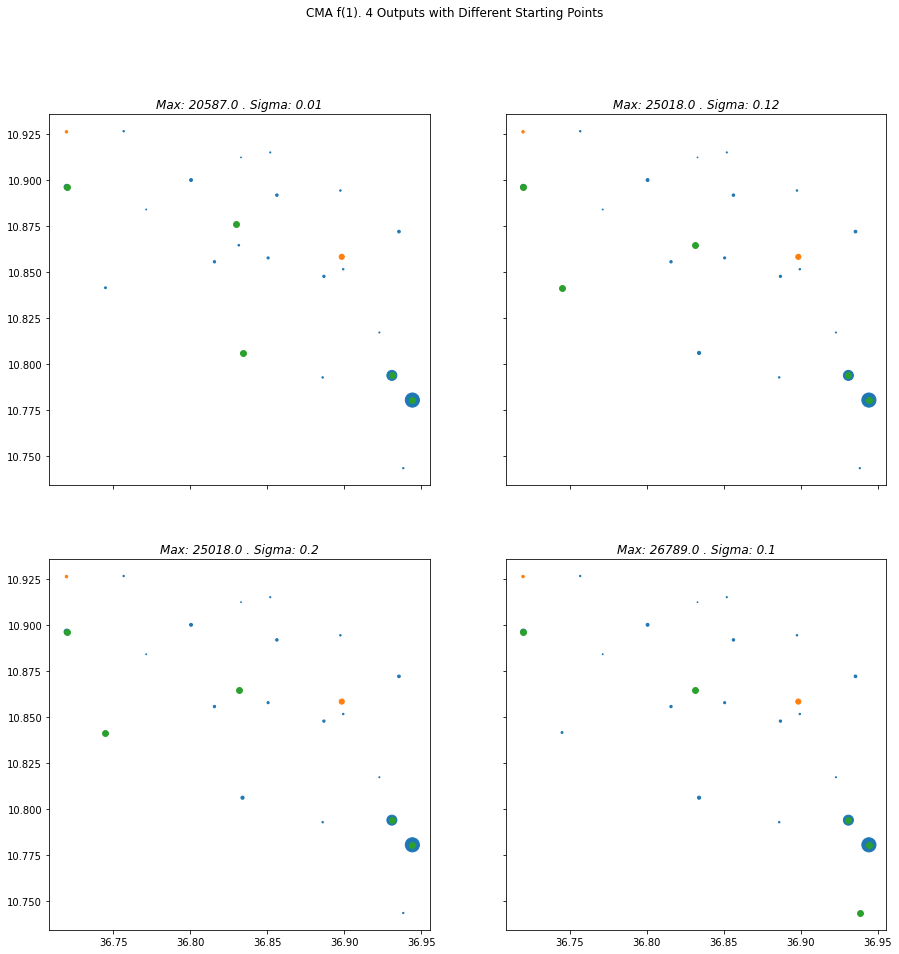

In [24]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA f(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma_s[i][1][1::2], fcma_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma_s[i][0],0))+ ' . Sigma: ' + str(fcma_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [25]:
fcma2 = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f2, iterations=maxits / es.popsize)
        fcma2.append((es.result[1], es.result[0], j))
        
fcma2_s = sorted(fcma2, key=lambda t: t[0])[:4]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:01:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -3.354900000000000e+04 1.0e+00 9.86e-03  9e-03  1e-02 0:00.0
    2     20 -3.494500000000000e+04 1.2e+00 1.01e-02  1e-02  1e-02 0:00.0
    3     30 -3.489400000000000e+04 1.3e+00 1.03e-02  1e-02  1e-02 0:00.0
  100   1000 -3.632300000000000e+04 6.4e+00 2.57e-03  7e-04  3e-03 0:00.5
  200   2000 -3.633900000000000e+04 8.9e+00 2.14e-04  3e-05  2e-04 0:00.8
  280   2800 -3.634100000000000e+04 1.7e+01 3.69e-05  4e-06  3e-05 0:01.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:01:11 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -2.214300000000000e+04 1.0e+00 4.82e-02  5e-02  5e-02 0:00.0
    2     20 -3.119400000000000e+04 1.2e+00 4.57e-02  4e-02  5e-02 0:00.0
    3     30 -3.376600000000000e+04 1.2e+00 4.17e-02  4e-02  4e-02 0:00.0
  100   10

    3     30 -3.113000000000000e+04 1.3e+00 9.71e-02  9e-02  1e-01 0:00.0
  100   1000 -3.477500000000000e+04 6.6e+00 4.16e-03  1e-03  6e-03 0:00.4
  200   2000 -3.477700000000000e+04 2.2e+01 1.88e-04  2e-05  2e-04 0:00.8
  223   2230 -3.477600000000000e+04 2.7e+01 9.55e-05  8e-06  1e-04 0:01.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:01:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -3.062200000000000e+04 1.0e+00 1.18e-01  1e-01  1e-01 0:00.0
    2     20 -2.464000000000000e+04 1.2e+00 1.11e-01  1e-01  1e-01 0:00.0
    3     30 -1.398000000000000e+04 1.2e+00 1.09e-01  1e-01  1e-01 0:00.0
  100   1000 -3.537800000000000e+04 8.8e+00 2.69e-02  6e-03  3e-02 0:00.5
  200   2000 -3.686400000000000e+04 1.7e+01 4.48e-03  6e-04  6e-03 0:00.9
  300   3000 -3.688500000000000e+04 3.2e+01 1.95e-04  1e-05  2e-04 0:01.4
  400   4000 -3.688600000000000e+04 5.6e+01 8.52e-05  4e-06  9e-05 0:01.9
(5_w,10)-aCMA-ES (mu_w=3

    2     20 -1.313100000000000e+04 1.2e+00 1.36e-01  1e-01  1e-01 0:00.0
    3     30 -3.321300000000000e+04 1.2e+00 1.31e-01  1e-01  1e-01 0:00.0
  100   1000 -3.545600000000000e+04 8.9e+00 1.65e-02  3e-03  2e-02 0:00.4
  200   2000 -3.565000000000000e+04 1.3e+01 1.86e-03  2e-04  2e-03 0:00.9
  300   3000 -3.565200000000000e+04 2.3e+01 1.46e-04  1e-05  1e-04 0:01.3
  347   3470 -3.565200000000000e+04 3.6e+01 1.69e-04  8e-06  1e-04 0:01.5
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:02:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -2.224200000000000e+04 1.0e+00 1.51e-01  1e-01  2e-01 0:00.0
    2     20 -3.314500000000000e+04 1.1e+00 1.43e-01  1e-01  1e-01 0:00.0
    3     30 -2.562600000000000e+04 1.2e+00 1.29e-01  1e-01  1e-01 0:00.0
  100   1000 -3.565800000000000e+04 1.1e+01 3.32e-02  6e-03  5e-02 0:00.4
  200   2000 -3.630900000000000e+04 2.9e+01 1.72e-03  1e-04  3e-03 0:00.9
  300   3000 -3.63080000

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:02:38 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -2.806500000000000e+04 1.0e+00 2.03e-01  2e-01  2e-01 0:00.0
    2     20 -3.319100000000000e+04 1.2e+00 1.94e-01  2e-01  2e-01 0:00.0
    3     30 -2.513400000000000e+04 1.3e+00 1.79e-01  2e-01  2e-01 0:00.0
  100   1000 -3.672600000000000e+04 8.2e+00 1.32e-02  3e-03  1e-02 0:00.5
  200   2000 -3.698700000000000e+04 1.2e+01 1.07e-03  2e-04  1e-03 0:01.0
  300   3000 -3.698800000000000e+04 2.1e+01 1.41e-04  1e-05  1e-04 0:01.5
  307   3070 -3.698700000000000e+04 2.1e+01 8.90e-05  6e-06  7e-05 0:01.5
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jul  1 10:02:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -3.423500000000000e+04 1.0e+00 2.06e-01  2e-01  2e-01 0:00.0
    2     20 -3.426200000000000e+04 1.1e+00 2.02e-01  2e-01  2e-01 0:00.0
    3     

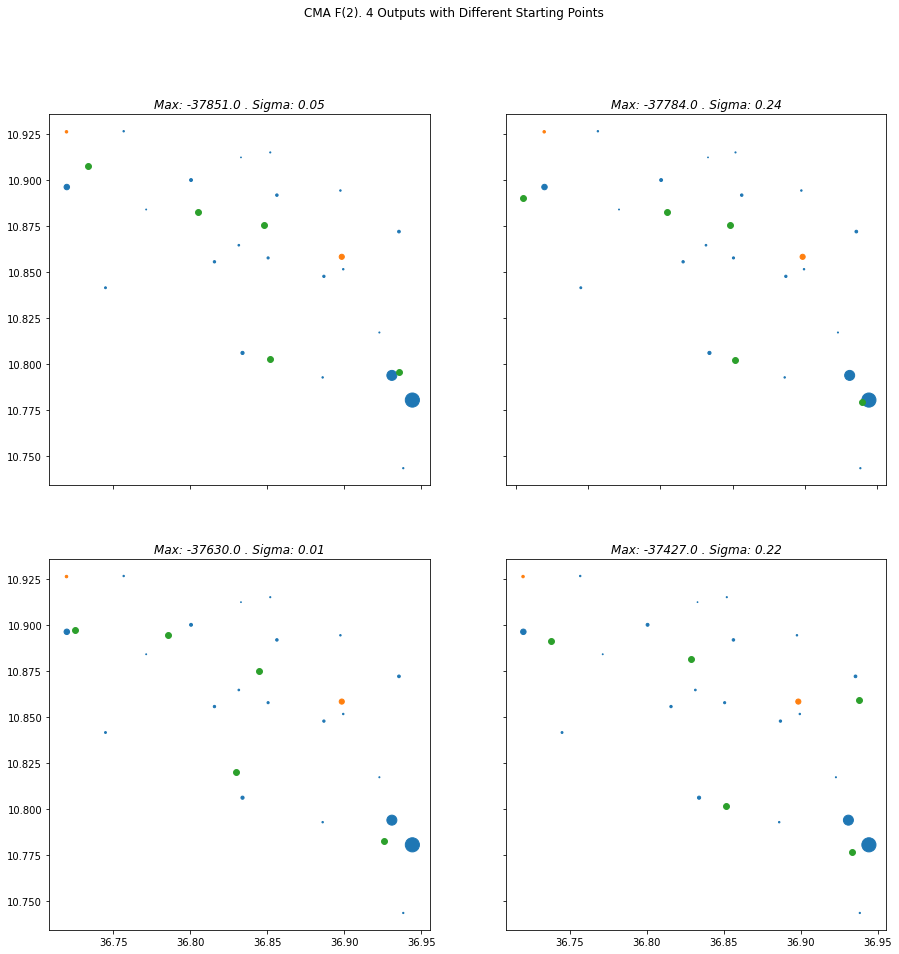

In [26]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma2_s[i][1][1::2], fcma2_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma2_s[i][0],0))+ ' . Sigma: ' + str(fcma2_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [46]:
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

In [58]:
df.columns

Index(['region', 'zone', 'woreda', 'school_name', 'school_code', 'geometry',
       'lat', 'lon', 'gr_offer', 'urban_rural', 'grade1_4', 'grade1_4_f',
       'grade1_4_m', 'grade5_8', 'grade5_8_f', 'grade5_8_m', 'grade9_10',
       'grade9_10_f', 'grade9_10_m', 'grade11_12', 'grade11_12_f',
       'grade11_12_m', 'water_y_n', 'has_separate_toilet', 'has_toilet',
       'ADM0_PCODE', 'ADM1_PCODE', 'ADM2_PCODE', 'ADM3_PCODE', 'ADM0_EN',
       'ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'point', 'nearest_up_prim',
       'nearest_sch_code', 'nearest_lwr_sec', 'nearest_up_sec'],
      dtype='object')

In [59]:
df2 = df[['region', 'zone','woreda','school_name', 'lat','lon', 'gr_offer', 'grade5_8', 'nearest_lwr_sec']]
df2

,region,zone,woreda,school_name,lat,lon,gr_offer,grade5_8,nearest_lwr_sec
0,Amhara,Agew awi,Ankesha,Buya,10.780600,36.944100,G.1-8,20000,6.420054
1,Amhara,Agew awi,Ankesha,Shashena,10.900100,36.800500,G.1-8,847,0.972089
2,Amhara,Agew awi,Ankesha,Denena Atequashita,10.872100,36.935400,G.1-8,730,4.328322
4,Amhara,Agew awi,Ankesha,eurna,10.891900,36.856200,G.1-8,620,5.291832
5,Amhara,Agew awi,Ankesha,Abita,10.806200,36.833900,G.1-8,1000,9.119160
6,Amhara,Agew awi,Ankesha,Demama,10.855700,36.815700,G.1-8,557,5.277130
7,Amhara,Agew awi,Ankesha,Sosetu G/bete,10.847800,36.886700,G.1-8,540,1.730323
8,Amhara,Agew awi,Ankesha,Mesela,10.896300,36.719900,G.1-8,3000,3.335924
9,Amhara,Agew awi,Ankesha,Gewona,10.857800,36.850500,G.1-8,458,5.220393
11,Amhara,Agew awi,Ankesha,Degeha,10.841600,36.745000,G.1-8,361,9.746861


In [ ]:
df2 = {'Region': region, 'zone': 'Agew awi', 'woreda': 'Ankesha', 'school_name': 'new_school1',\
      'lat':, 'lon':, 'gr_offer':}


In [55]:
df_prim_loc

array([[10.7806  , 36.9441  ],
       [10.9001  , 36.8005  ],
       [10.8721  , 36.9354  ],
       [10.8919  , 36.8562  ],
       [10.8062  , 36.8339  ],
       [10.8557  , 36.8157  ],
       [10.8478  , 36.8867  ],
       [10.8963  , 36.7199  ],
       [10.8578  , 36.8505  ],
       [10.8416  , 36.745   ],
       [10.8647  , 36.8315  ],
       [10.894407, 36.897415],
       [10.851659, 36.89926 ],
       [10.7929  , 36.8859  ],
       [10.9266  , 36.7568  ],
       [10.794   , 36.9308  ],
       [10.7436  , 36.9382  ],
       [10.9151  , 36.8519  ],
       [10.8173  , 36.9227  ],
       [10.8841  , 36.7714  ],
       [10.9124  , 36.8329  ]])

In [56]:
fig = px.scatter_mapbox(lat=fcma2[0][1][::2], lon=fcma2[0][1][1::2],
                       mapbox_style='open-street-map', zoom=10)

px.scatter_mapbox(lat=df_prim_loc[::2], lon=df_prim_loc[1::2],
                       mapbox_style='open-street-map', zoom=10)

fig.show()

Exception: Data must be 1-dimensional